<a href="https://colab.research.google.com/github/argbiswas/FaultFindy-Build-intelligence-using-Machine-Learning-to-predict-the-faulty-tyre-in-manufacturing-/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import time
import matplotlib.pyplot as plt
from fastai.vision.all import *
import torch
import numpy as np
import random
from sklearn.metrics import roc_curve, auc

In [ ]:
# Seed function to set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# Set the seed for reproducibility
set_seed(42)

In [ ]:
# Data loaders setup
path = r'C:\Users\argha\Downloads\Fraud\Digital images of defective and good condition tyres'
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
)
dls = data.dataloaders(path)

Number of training examples: 1485, Number of validation examples: 371


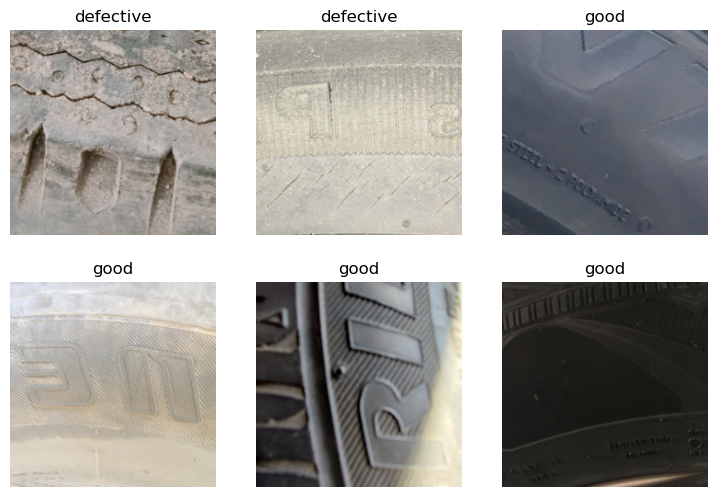

In [ ]:
dls.show_batch(max_n=6)
print(f"Number of training examples: {len(dls.train_ds)}, Number of validation examples: {len(dls.valid_ds)}")

In [ ]:
metrics = [accuracy, RocAucBinary()]

# Function to plot ROC Curve
def plot_roc_curve(learn, title="ROC Curve"):
    preds, targets = learn.get_preds()
    fpr, tpr, thresholds = roc_curve(targets, preds[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

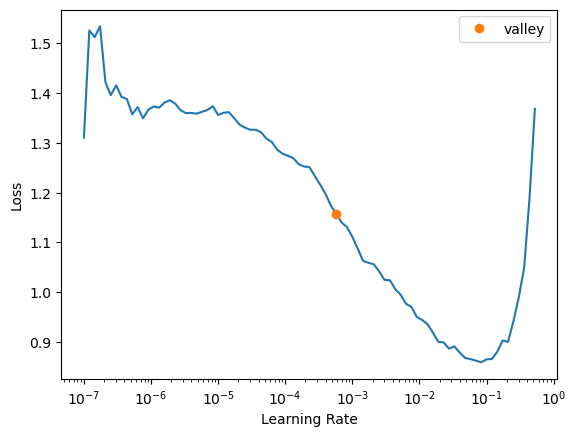

In [ ]:
learn_resnet34 = vision_learner(dls, resnet34, metrics=metrics)
lr_resnet34 = learn_resnet34.lr_find()

In [ ]:
start_time_resnet34 = time.time()

learn_resnet34.fine_tune(10, base_lr=lr_resnet34.valley, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

end_time_resnet34 = time.time()
training_time_resnet34 = end_time_resnet34 - start_time_resnet34
training_time_resnet34

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.965753,0.438234,0.835580,0.922542,18:11


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.451896,0.341416,0.862534,0.948623,20:28
1,0.417657,0.238366,0.913747,0.970629,18:45
2,0.342388,0.189269,0.921833,0.980992,19:05
3,0.282051,0.151925,0.938005,0.988182,18:39
4,0.232811,0.131788,0.954178,0.991122,23:07
5,0.179207,0.143393,0.951482,0.991442,22:46
6,0.145647,0.135034,0.956873,0.992257,22:31
7,0.113139,0.124960,0.956873,0.993305,20:30
8,0.089469,0.123805,0.959569,0.993392,18:28
9,0.078431,0.112788,0.954178,0.993713,18:28


13264.485234975815

In [ ]:
accuracy_resnet34 = learn_resnet34.validate()[1]
accuracy_resnet34

0.9541779160499573

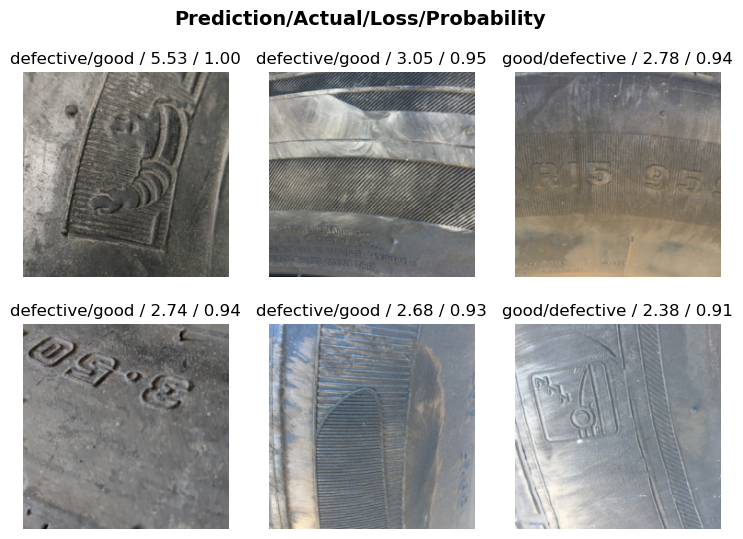

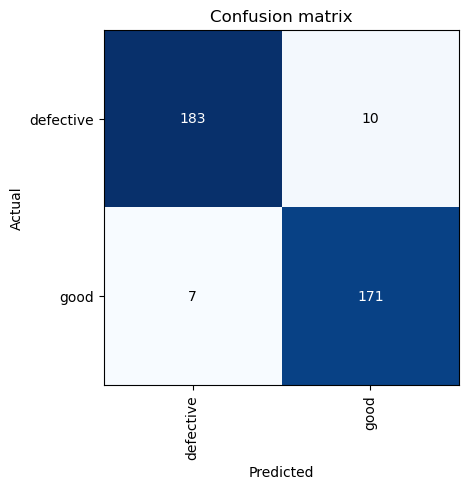

In [ ]:
interp_resnet34 = ClassificationInterpretation.from_learner(learn_resnet34)
interp_resnet34.plot_top_losses(k=6)
interp_resnet34.plot_confusion_matrix()
plt.show()

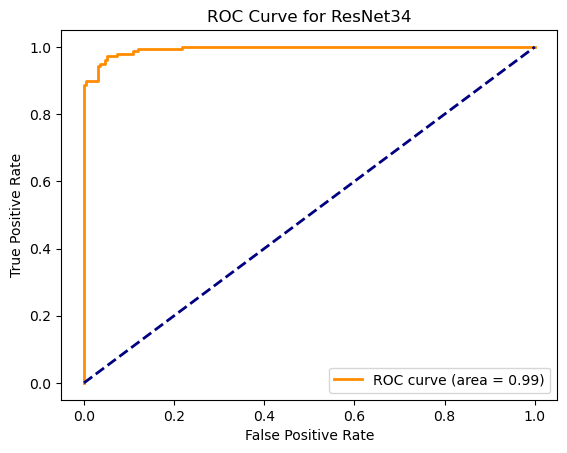

In [ ]:
plot_roc_curve(learn_resnet34, "ROC Curve for ResNet34")

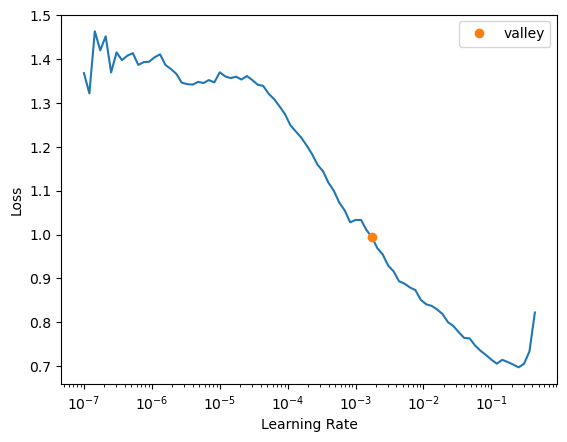

In [ ]:
learn_resnet50 = vision_learner(dls, resnet50, metrics=metrics)
lr_resnet50 = learn_resnet50.lr_find()

In [ ]:
start_time_resnet50 = time.time()

learn_resnet50.fine_tune(10, base_lr=lr_resnet50.valley, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

end_time_resnet50 = time.time()
training_time_resnet50 = end_time_resnet50 - start_time_resnet50
training_time_resnet50

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.651014,0.306569,0.892183,0.966758,24:06


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.278480,0.167353,0.951482,0.985504,32:13
1,0.218111,0.101249,0.948787,0.994673,40:42
2,0.169069,0.120912,0.975741,0.992141,39:37
3,0.124263,0.122461,0.967655,0.993800,30:20
4,0.100512,0.149465,0.964960,0.990860,30:21


No improvement since epoch 1: early stopping


11842.044347286224

In [ ]:
accuracy_resnet50 = learn_resnet50.validate()[1]
accuracy_resnet50

0.9649595618247986

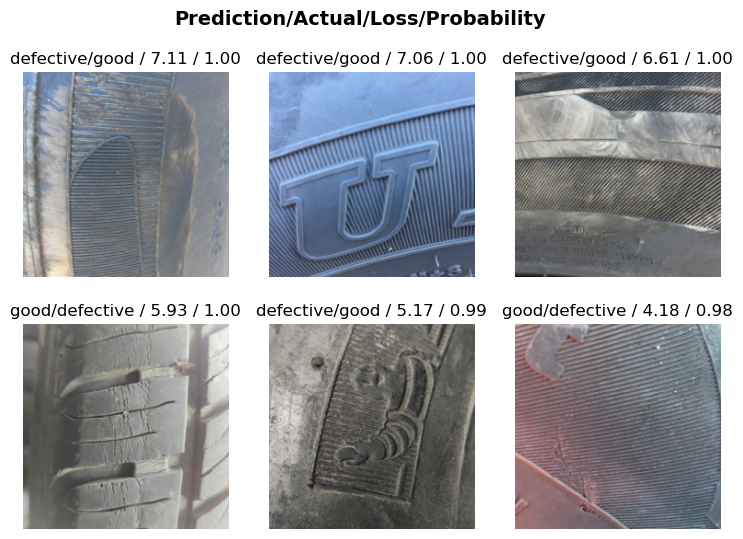

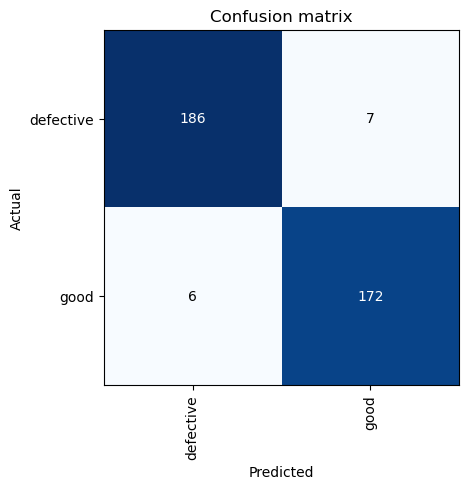

In [ ]:
interp_resnet50 = ClassificationInterpretation.from_learner(learn_resnet50)
interp_resnet50.plot_top_losses(k=6)
interp_resnet50.plot_confusion_matrix()
plt.show()

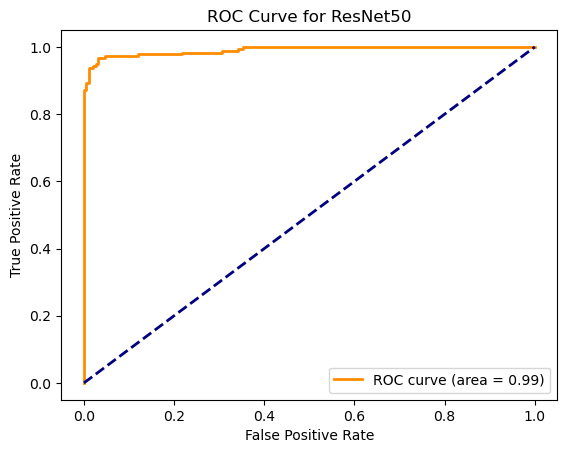

In [ ]:
# Plot ROC Curve for ResNet50
plot_roc_curve(learn_resnet50, "ROC Curve for ResNet50")

In [ ]:
print(f"Training time for ResNet34: {training_time_resnet34:.2f} seconds")
print(f"Accuracy for ResNet34: {accuracy_resnet34:.4f}")
print(f"Training time for ResNet50: {training_time_resnet50:.2f} seconds")
print(f"Accuracy for ResNet50: {accuracy_resnet50:.4f}")

Training time for ResNet34: 13264.49 seconds
Accuracy for ResNet34: 0.9542
Training time for ResNet50: 11842.04 seconds
Accuracy for ResNet50: 0.9650


In [ ]:
learn_resnet34.export('resnet34_model.pkl')
learn_resnet50.export('resnet50_model.pkl')

In [ ]:
import time
import ipywidgets as widgets
from IPython.display import display
from fastai.vision.all import PILImage, load_learner
from PIL import UnidentifiedImageError

# Models
models = {'ResNet34': 'resnet34_model.pkl', 'ResNet50': 'resnet50_model.pkl'}

# Load selected model
def load_model(change):
    global learn
    learn = load_learner(models[change.new])

# Widget holder
vbox = widgets.VBox()

# Title and description
title = widgets.HTML('<h1>Tyre Defect Classifier</h1>')
description = widgets.HTML('<p>This tool classifies tyres as defective or good.</p>')
vbox.children += (title, description,)

# Dropdown for model selection
model_selector = widgets.Dropdown(options=models.keys(), description='Model:')
model_selector.observe(load_model, names='value')
vbox.children += (model_selector,)

# Load the initial model
learn = load_learner(models[model_selector.value])

# File upload widget
uploader = widgets.FileUpload()
vbox.children += (widgets.Label('Upload your image:'), uploader,)

# Button for predictions
predict_btn = widgets.Button(description="Predict", disabled=True, button_style='success')
vbox.children += (predict_btn,)

# Output widgets, showing image and label
output_image = widgets.Output()
output_label = widgets.Label()
vbox.children += (output_image, output_label,)

# Change states of the button
def update_button_state(change):
    predict_btn.disabled = not bool(uploader.data)

uploader.observe(update_button_state, names='data')

# Define the prediction function
def on_click_classify(change):
    output_image.clear_output()
    output_label.value = ''
    if uploader.data:
        try:
            img = PILImage.create(uploader.data[-1])
            with output_image:
                display(img.to_thumb(128, 128))
            start_time = time.time()
            pred, _, probs = learn.predict(img)
            end_time = time.time()
            output_label.value = f'Prediction: {pred}; Probability: {max(probs):.04f}; Time taken: {end_time - start_time:.2f} seconds'
        except UnidentifiedImageError:
            output_label.value = 'Error: Uploaded file is not a valid image. Please upload a valid image file.'
        except Exception as e:
            output_label.value = f'Error: {str(e)}'

             # Clear the uploader's data
        uploader.value.clear()
        uploader._counter = 0
        predict_btn.disabled = True

# Attach the event handler to the predict button
predict_btn.on_click(on_click_classify)

# Display the VBox
display(vbox)